In [1]:
%load_ext autoreload
%autoreload

In [12]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import rl_salk
from rl_salk.agents.q_learner import QLearner
from rl_salk.agents.sarsa_learner import SarsaLearner
from rl_salk.envs.cliff_walk_env import ACTION_TO_DELTA

%matplotlib inline

In [5]:
env = gym.make('cliff-walk-v0')

n_states = np.prod(env.grid_size)
n_actions = 4

q_learner = QLearner(n_states, n_actions, epsilon=0.1, gamma=1.0, alpha=0.1)
sarsa_learner = SarsaLearner(n_states, n_actions, epsilon=0.1, gamma=1.0, alpha=0.1)

def obs_to_state(env, obs):
    pos = obs['current_pos']
    state = pos[1] * env.grid_size[0] + pos[0]
    return state

def train_agent(agent, env):

    n_states = np.prod(env.grid_size)
    n_actions = 4

    obs = env.reset()
    state = obs_to_state(env, obs)
    agent.reset(state)

    max_iters = 50000
    iters = 0
    desired_episodes = 500
    
    episodes = []
    current_episode = []

    while len(episodes) < desired_episodes:

        action = agent.sample_action(state)
        (obs, reward, done, info) = env.step(action)
        new_state = obs_to_state(env, obs)
        agent.learn(state, action, new_state, reward, done)
        current_episode.append((state, action, new_state, reward, done))

        if iters >= max_iters:
            done = True
        
        if done:
            obs = env.reset()
            state = obs_to_state(env, obs)
            agent.reset(state)
            episodes.append(current_episode)
            current_episode = []
        else:
            state = new_state
        
        iters += 1

    env.close()
    
    return episodes

q_runs = []
sarsa_runs = []
for _ in range(100):
    q_runs.append(train_agent(q_learner, env))
    sarsa_runs.append(train_agent(sarsa_learner, env))

In [8]:
[len(x[1]) for x in sarsa_runs]

[902,
 15,
 17,
 17,
 17,
 15,
 15,
 15,
 17,
 17,
 24,
 24,
 19,
 21,
 17,
 17,
 17,
 16,
 23,
 20,
 19,
 19,
 17,
 17,
 17,
 19,
 22,
 21,
 20,
 15,
 15,
 17,
 22,
 17,
 21,
 17,
 17,
 17,
 17,
 21,
 23,
 19,
 21,
 17,
 18,
 18,
 21,
 17,
 22,
 17,
 20,
 17,
 20,
 19,
 17,
 18,
 17,
 17,
 19,
 22,
 19,
 21,
 17,
 17,
 19,
 20,
 17,
 17,
 25,
 17,
 19,
 19,
 21,
 17,
 23,
 19,
 17,
 23,
 17,
 23,
 17,
 17,
 19,
 17,
 18,
 20,
 17,
 19,
 23,
 18,
 24,
 17,
 39,
 19,
 17,
 17,
 22,
 17,
 23,
 23]

In [20]:
def render_gridworld_q(q, grid_size):
    shape = (grid_size[1], grid_size[0], 4)
    q_ = np.reshape(q, shape)
    action_array = np.argmax(q_, axis=2)
    for y in range(action_array.shape[0]):
        for x in range(action_array.shape[1]):

            # plot arrow
            action = action_array[y, x]
            delta = ACTION_TO_DELTA[action] * 0.3
            plt.arrow(x, y, delta[0], delta[1], head_width=0.1, fill=False)

            # plot square
            pos = np.array((x, y))

            on_cliff = env.on_cliff(pos)
            at_start = env.at_start(pos)
            at_goal = env.at_goal(pos)

            fill = on_cliff or at_start or at_goal

            facecolor = None
            if on_cliff:
                facecolor = None
            if at_start:
                facecolor = 'green'
            if at_goal:
                facecolor = 'red'

            rect = patches.Rectangle((x - 0.5, y - 0.5), 1, 1, fill=fill, edgecolor='black', color=facecolor)
            ax = plt.gca()
            ax.add_patch(rect)

    plt.axis('off')
    plt.axis('equal')
    plt.ylim((grid_size[1], -2))
    plt.xlim((-2, 13))


//anaconda3/envs/gym/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


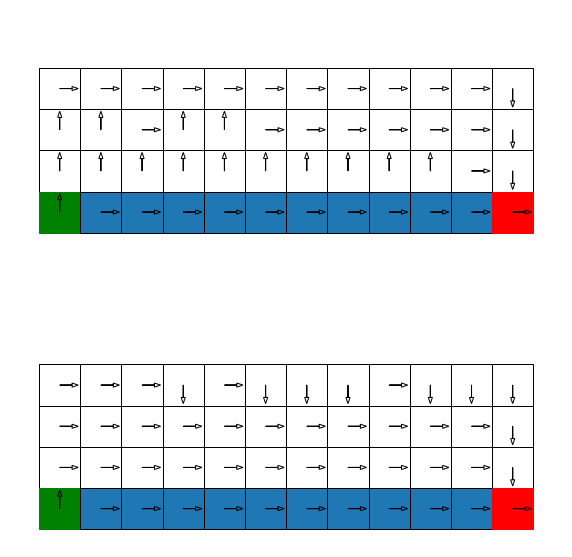

In [22]:
plt.figure(figsize=(10,10))

plt.subplot(211)
render_gridworld_q(sarsa_learner.q, grid_size)

plt.subplot(212)
render_gridworld_q(q_learner.q, grid_size)

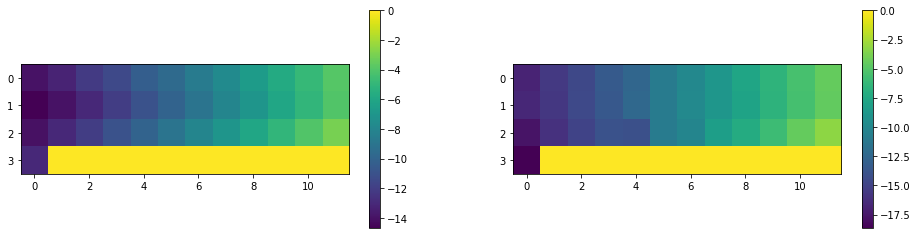

In [129]:
plt.figure(figsize=(25,4))

action = 3

plt.subplot(131)
plt.imshow(np.reshape(q_learner.q, (4, 12, 4))[:,:,action], interpolation='nearest')
plt.colorbar()

plt.subplot(132)
plt.imshow(np.reshape(sarsa_learner.q[:, action], (4, 12)), interpolation='nearest')
plt.colorbar()


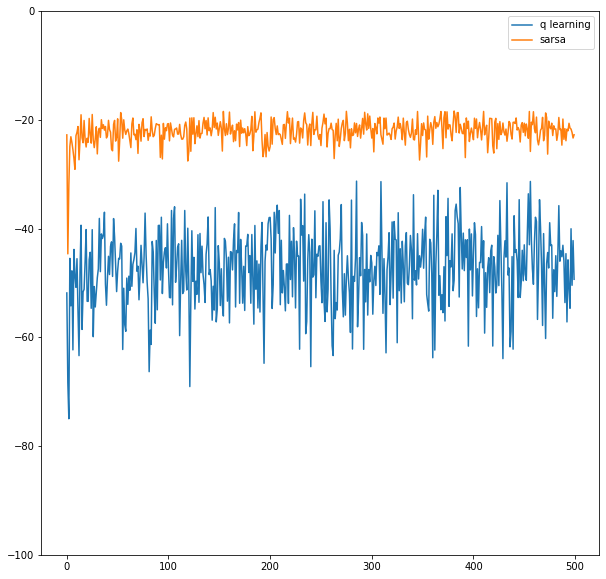

In [23]:
q_scores = np.array([[np.sum([r for (_, _, _, r, _) in ep]) for ep in run] for run in q_runs])
sarsa_scores = np.array([[np.sum([r for (_, _, _, r, _) in ep]) for ep in run] for run in sarsa_runs])

q_means = np.mean(q_scores, axis=0)
sarsa_means = np.mean(sarsa_scores, axis=0)

plt.figure(figsize=(10,10))

plt.plot(q_means, label='q learning')
plt.plot(sarsa_means, label='sarsa')

plt.ylim(-100, 0)
plt.legend()